# Mortality rate predictions for Italy in 2020

Mortality rate predictions for Italy in 2020 using Lee-Carter model and Recurrent Neural Networks

Predict total italian mortality rate in 2020 with the following models: 

* Lee-Carter 
* Bayesian Lee-Carter
* Shallow LSTM 
* Shallow time-distributed LSTM
* Deep LSTM 
* Deep GRU 

The dataset contains observations of mortality rate from 1974 to 2020 for 24 different age classes, ranging from age 0 to age 199 (source: ISTAT). Each age class $x$ is predicted using the two adjacent age classes $x-1$ and $x+1$ as features in the RNN models. 

The shallow LSTM and time-distributed LSTM are used to produce a one-step-ahead forecasts for 2020, while the remaining models are used to produce a 10-step-ahead forecast for the period 2010-2020.

In [2]:
require(data.table)
require(dplyr)
require(reshape2)
require(zoo)
require(keras)
require(StanMoMo)

set.seed(1234)

Loading required package: data.table

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: reshape2


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: keras

Loading required package: StanMoMo



#### Data analysis 

* ISTAT dataset on probability of death by age class for Italy

* 24 different age classes from age 0 to age 119

* Data from 1974 to 2020

In [4]:
import = read.csv("./istat_mortality.csv", sep = ",")
head(import)

,ITTER107,Territory,TIPO_DATO15,Biometric.functions,SEXISTAT1,Gender,ETA1,Age.and.age.class,TIME,Select.time,Value,Flag.Codes,Flags
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<lgl>,<lgl>
1,IT,Italy,PYLIVED,years lived - Lx,9,total,Y5-9,5-9 years,1974,1974,485849,NA,NA
2,IT,Italy,PYLIVED,years lived - Lx,9,total,Y5-9,5-9 years,1975,1975,486443,NA,NA
3,IT,Italy,PYLIVED,years lived - Lx,9,total,Y5-9,5-9 years,1976,1976,487421,NA,NA
4,IT,Italy,PYLIVED,years lived - Lx,9,total,Y5-9,5-9 years,1977,1977,488147,NA,NA
5,IT,Italy,PYLIVED,years lived - Lx,9,total,Y5-9,5-9 years,1978,1978,489001,NA,NA
6,IT,Italy,PYLIVED,years lived - Lx,9,total,Y5-9,5-9 years,1979,1979,489703,NA,NA


In [5]:
# convert age classes to numeric and use only upper bound to denote class
classes = import$'Age.and.age.class'
res1 = gsub(" years", "", classes)
res1[res1 == "until 4"] = "0-4"
class_new = as.numeric( sub(".*-", "", res1) )
import$age = class_new

In [6]:
# create variables death probability (mx), log death probability (logmx) and age class
dati_istat = import[import$Biometric.functions == "probability of death (per thousand) - qx", ]
dati_istat$mx = dati_istat$Value/1000
dati_istat$logmx = log(dati_istat$mx)


In [7]:
dati_istat = dati_istat[, c("age", "TIME", "mx", "logmx")]
dati_istat = dati_istat[order(dati_istat$age), ]
dati_istat = dati_istat[order(dati_istat$TIME), ]


head(dati_istat)

,age,TIME,mx,logmx
,<dbl>,<int>,<dbl>,<dbl>
1082,4,1974,0.02734902,-3.599075
424,9,1974,0.00185126,-6.291889
330,14,1974,0.00175155,-6.347254
565,19,1974,0.00345069,-5.669181
1270,24,1974,0.00398984,-5.524004
1129,29,1974,0.00382141,-5.567136


### Log mortality rates

Blue = low mortality rate and red = high mortality rate

Slight improvement in mortality rate over time

In [8]:
nr_classes = length(unique(dati_istat$age))
tot_length = length(dati_istat[, "logmx"])

matrix_fin = t( matrix(dati_istat[, "logmx"], nrow = nr_classes, ncol = tot_length/nr_classes) )
dim(matrix_fin)

[1] 47 24

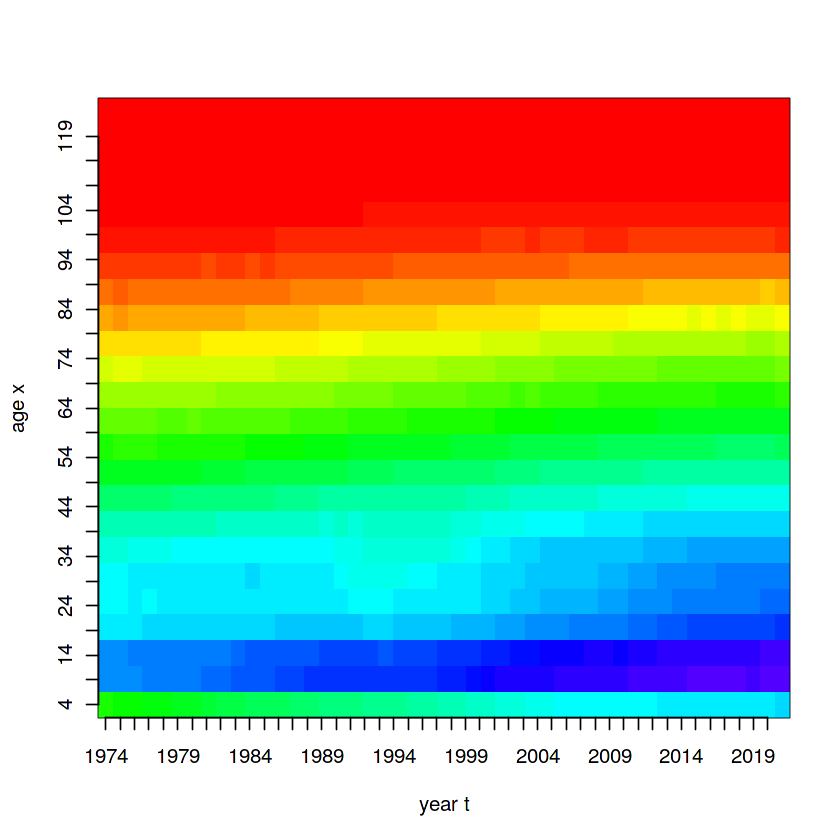

In [9]:
m0 <- c(min(dati_istat$logmx), max(dati_istat$logmx))
# rows are calendar year t, columns are ages x
image(z=matrix_fin, useRaster=TRUE,  zlim=m0, col=rev(rainbow(n=60, start=0, end=.72)), xaxt='n', yaxt='n', ylab="age x", xlab="year t")
axis(1, at = (0:(nrow(matrix_fin)-1))/nrow(matrix_fin), label = unique(dati_istat$TIME))
axis(2, at = (0:(ncol(matrix_fin)-1))/ncol(matrix_fin), label = unique(dati_istat$age))

# Lee-Carter model

Force of mortality: 

$$
log(m_{t,x}) = a_x + b_x k_t
$$

where 

* $m_{t,x}$ = morality rate in year $t$ for a person aged $x$
* $a_x$ = average log-mortality rate for a person aged $x$
* $k_t$ = time index for annual mortality rate changes
* $b_x$ = rate of change over time for a person aged $x$

Fit model by singular value decomposition: 

1) Divide the sample in training and test set

2) Subtract mean from log mortality rates 

$$
log(M_{t, x}^i) = log(m_{t, x}^i) - \hat{a}_x
$$

where $\hat{a}_x = 1/T \sum_{t=1}^T log(m_{t, x}^i)$

3) Find optimal values for $b_x$ and $k_t$

$$
\underset{b_x, k_t}{argmin} \sum_{t, k} log(M_{t, x}^i - b_x k_t)^2
$$

Define $A = log(M_{t, x}^i)$: 

* $\hat{b}_x$ = product between the first singular vector and the first singular value of A
* $\hat{k}_t$ = first right singular vector of A

4) Normalize the estimates such that 


$$
\sum_{x} \hat{b}_x = 1, \sum_{t} \hat{k}_t = 0 
$$

5) Predict $k_t$ as a random walk with drift

$$
k_t \sim N(c + k_{t-1}, \sigma)
$$

In [10]:
split_data = function(data, time){
    
    train = data[data$TIME <= time, ]
    test = data[data$TIME > time, ]
    return(list(train = train, test = test))
}

In [11]:
# split data into training and test set
data_new = split_data(dati_istat, 2010)
train = data_new$train
test = data_new$test

In [12]:
# compute mean by age class and center data
train = data.table(train)
train[, ax:= mean(logmx), by = (age)]
train[, mx_adj:= logmx-ax]  
head(train)

age,TIME,mx,logmx,ax,mx_adj
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
4,1974,0.02734902,-3.599075,-4.685485,1.0864108
9,1974,0.00185126,-6.291889,-7.037604,0.7457148
14,1974,0.00175155,-6.347254,-6.888291,0.5410369
19,1974,0.00345069,-5.669181,-6.000442,0.3312607
24,1974,0.00398984,-5.524004,-5.764635,0.2406309
29,1974,0.00382141,-5.567136,-5.708903,0.1417670


In [13]:
# reashape matrix and fit svd
rates = dcast(train, age ~ TIME, value.var = "mx_adj")[, -1]
svd_fit <- svd(rates)

In [14]:
# parameter estimates
ax = train[, unique(ax)]
bx = svd_fit$u[,1]*svd_fit$d[1]
kt = svd_fit$v[,1]

In [15]:
round( sum(bx) )
round( sum(kt) )

[1] -29

[1] 0

In [16]:
# normalize kt and bx
c1 = mean(kt)
c2 = sum(bx)

ax <- ax + c1*bx
bx <- bx/c2
kt <- (kt- c1)*c2

In [17]:
sum(bx)
round( sum(kt) )

[1] 1

[1] 0

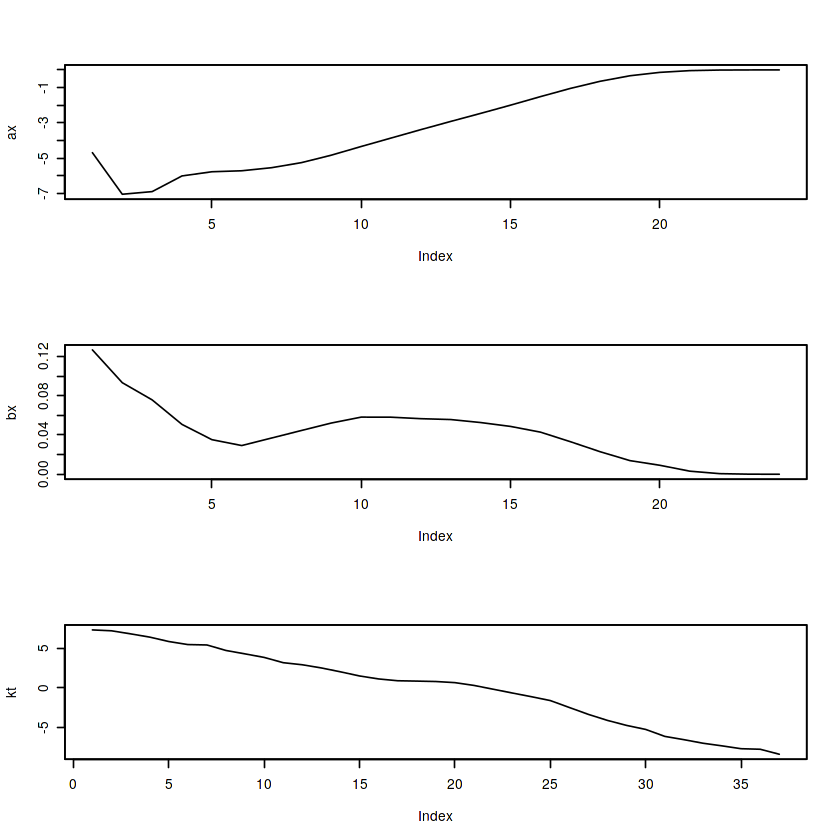

In [18]:
par(mfrow = c(3, 1))
plot.zoo(ax)
plot.zoo(bx)
plot.zoo(kt)

In [19]:
# forecast kt with random walk with drift
H = length(unique(test$TIME))
kt_fcst = forecast::rwf(kt, h = H, drift = T)$mean

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



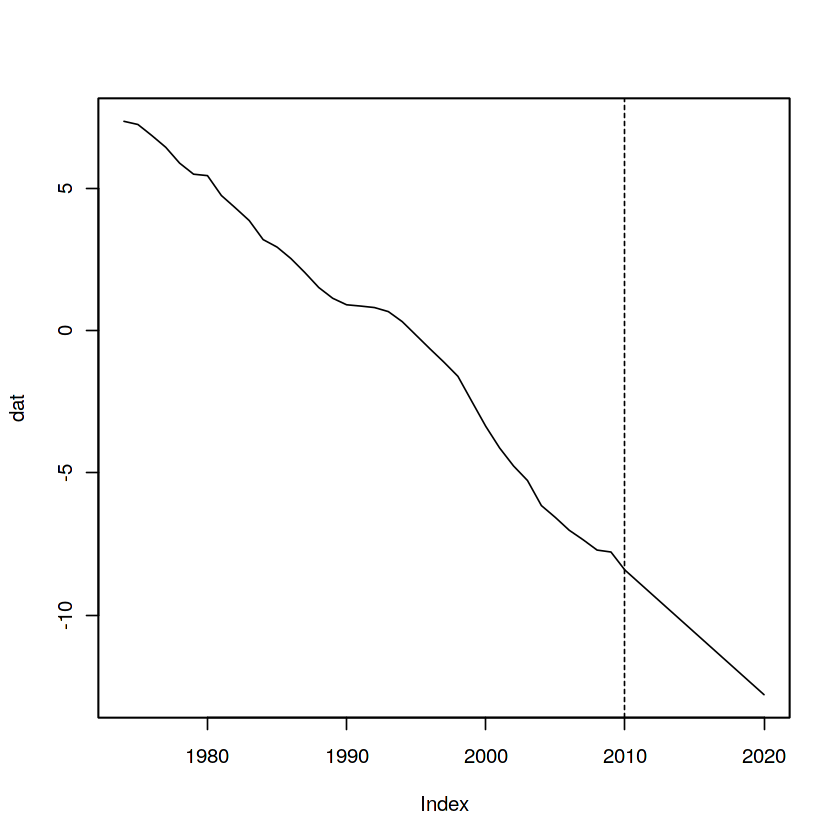

In [20]:
dat = ts( c(kt, kt_fcst), start = unique(dati_istat$TIME)[1])
plot.zoo(dat)
abline(v = 2010, lty = "dashed")

In [21]:
# estimate + forecast of mx

fit_train = ax + (bx) %*% t(kt)
train_agg = melt(fit_train)$value
mx_train = exp(train_agg)

fit_test = ax + (bx) %*% t(kt_fcst)
test_agg = melt(fit_test)$value
mx_test = exp(test_agg)

In [22]:
train_err = mean( (train$mx - mx_train)^2 )*10^2
test_err = mean((test$mx - mx_test)^2)*10^2

train_err0 = tail(train_err, 24)
test_err0 = tail(test_err, 24)

round(c(train_err0, test_err0), 4)

[1] 0.0042 0.0129

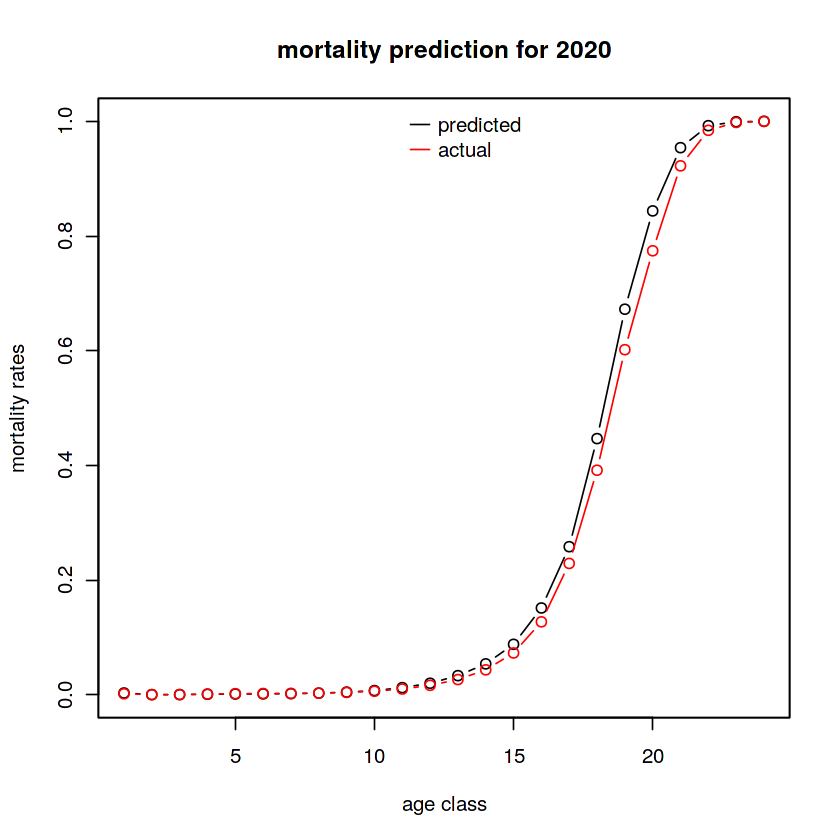

In [23]:
yhat0 = tail( test$mx, 24)

plot.zoo( cbind(yhat0, tail( mx_test, 24)), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

# Bayesian estimation of Lee-Carter model 

Estimate Lee-Carter model parametrers under a Poisson model with the R library "StanMomo"

$$
D_{x,t} \sim Poisson(e_{x,t} m_{x,t} )
$$

where $m_{x,t}$ is the mortality rate and $e_{x,t}$ is the exposure.

In [24]:
# extract total deaths 
death_it = import[import$Biometric.functions == "deaths - dx", ]
death_it = death_it[, c("TIME", "age", "Value")]

# split dataset
death_new = split_data(death_it, 2010)
death_train = death_new$train
death_test = death_new$test

# convert to matrix (age class x year)
train_app = dcast(death_train, age ~ TIME, value.var = "Value")
train_d = train_app[, -1]
rownames(train_d) = train_app[, 1]
head(train_d)

,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,⋯,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,2735,2621,2430,2287,2121,1986,1850,1720,1540,1447,⋯,544,509,480,442,419,402,386,375,380,381
9,180,172,165,161,153,143,143,135,134,121,⋯,55,56,54,51,48,46,46,44,44,41
14,170,164,158,159,155,155,159,151,143,129,⋯,76,71,66,61,60,57,57,56,58,54
19,334,326,316,314,298,295,305,307,306,295,⋯,207,196,186,180,169,162,158,157,154,142
24,385,371,358,360,346,344,347,345,336,323,⋯,301,277,250,239,236,237,225,210,204,188
29,368,358,352,355,352,352,353,345,334,325,⋯,303,287,265,256,258,259,248,230,221,206


In [25]:
# extract exposures
exposure_it = import[import$Biometric.functions == "survivors - lx", ]
exposure_it = exposure_it[, c("TIME", "age", "Value")]

# split dataset
exposure_new = split_data(exposure_it, 2010)
exposure_train = exposure_new$train
exposure_test = exposure_new$test

# convert to matrix (age class x year)
train_app = dcast(exposure_train, age ~ TIME, value.var = "Value")
train_e = train_app[, -1]
rownames(train_e) = train_app[, 1]
head(train_e)

,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,⋯,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,⋯,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
9,97265,97379,97570,97713,97879,98014,98150,98280,98460,98553,⋯,99456,99491,99520,99558,99581,99598,99614,99625,99620,99619
14,97085,97207,97405,97552,97726,97871,98007,98145,98325,98432,⋯,99400,99435,99466,99507,99533,99552,99568,99581,99576,99578
19,96915,97043,97247,97393,97571,97716,97848,97994,98182,98303,⋯,99325,99364,99399,99446,99473,99495,99511,99526,99518,99524
24,96581,96717,96931,97079,97273,97421,97543,97687,97875,98008,⋯,99118,99169,99214,99266,99304,99332,99353,99368,99364,99382
29,96195,96346,96573,96719,96927,97077,97197,97342,97539,97684,⋯,98817,98892,98964,99027,99067,99096,99129,99159,99160,99194


In [26]:
fitLC=lc_stan(death = as.matrix(train_d),
              exposure= as.matrix(train_e), 
              forecast = H, 
              family = "poisson",
              chains=1,
              iter=1000,
              cores=getOption("mc.cores", 1L))


SAMPLING FOR MODEL 'leecarter' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000338 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.38 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 45.5442 seconds (Warm-up)
Chain 1:                64.3256 seconds (Sampling)
Chain 1:                109.87 seco

In [27]:
params<-rstan::extract(fitLC)

In [28]:
# forecast of k_t
k_stan = rbind(t(params$k), t(params$k_p))
k_fcst = apply( k_stan, 1, median)
k_fcst = ts(k_fcst, start = unique(death_train$TIME)[1])

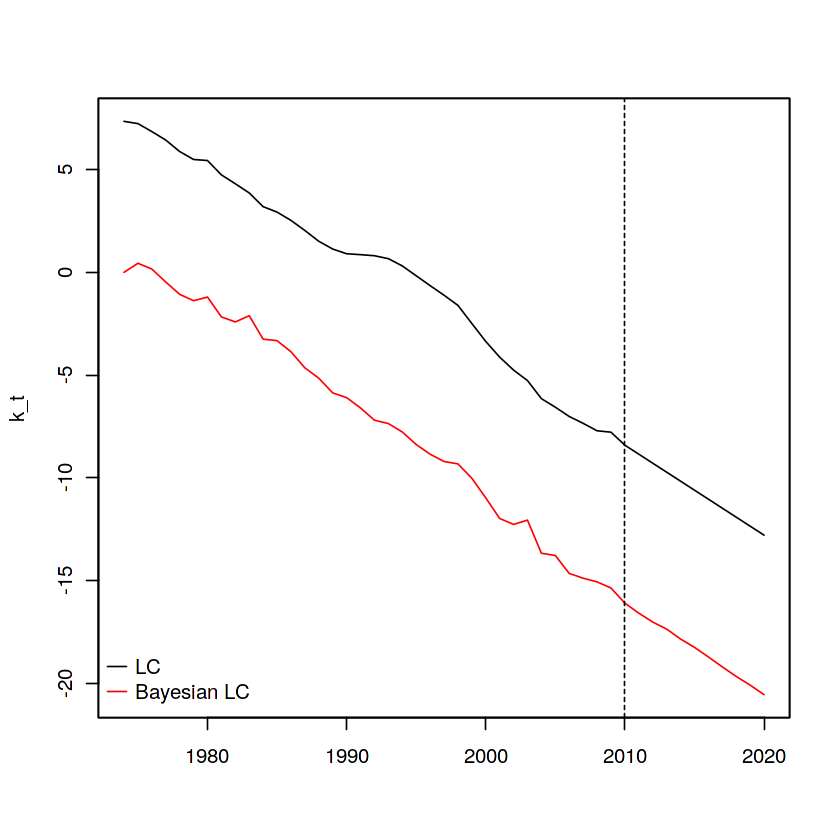

In [29]:
dat2 = cbind(dat, k_fcst)
plot.zoo(dat2, plot.type = "single", col = 1:2, ylab = "k_t", xlab = "")
abline(v = 2010, lty = "dashed")
legend("bottomleft", c("LC", "Bayesian LC"), col = 1:2, lty = 1, bty = "n")

In [30]:
mu_fcst = apply( params$mufor, 2, median)
test_err = mean((test$mx - mu_fcst)^2)*10^2
test_err01 = tail(test_err, 24)

round(test_err01, 4)

[1] 1.3132

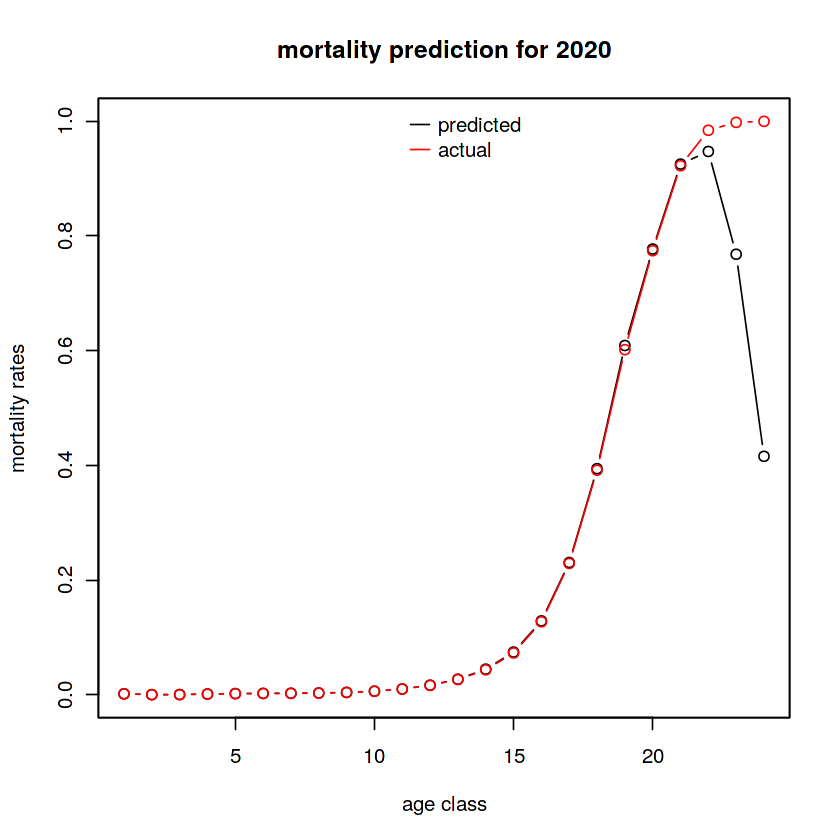

In [31]:
yhat01 = tail( mu_fcst, 24)

plot.zoo( cbind(yhat01, tail( mx_test, 24)), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

# Shallow LSTM

* Allow cycles of signal transmission from time step to time step, so as to respect time and causal relationships between lags of $x_t$. 

* LSTM with 1 hidden layer and 5 hidden neurons 
* Use adjacent age classes as features to predict mortality of a central age class $x$, for $x = 1,..., X$ and $X = 24$. Add padding at the age boundaries to include all age classes.
* The function in the output layer is the exponential function, since the output variable $y_t$ must be strictly positive.

## Shallow LSTM, 1-step-ahead forecast

* Use last 10 observations as training set: $T = 10$

* Input dimension $ T \times \tau_0$ with $\tau_0 = 3$, i.e. use two adjacent age classes $x-1$ and $x+1$ to explain central age class $x$.

The training set consists of a $T \times \tau_0$ matrix for every age class:

$$
x_{t, x} = (log(m_{t, x-1}), log(m_{t, x}), log(m_{t, x+1})), t = 2008, ..., 2018
$$

The test set is a $T \times \tau_0$ matrix shifted by one time step, so that the data start in 2009.

* The target variable is

$$
y_{T, x} = log(m_{T, x})
$$

with $T = 2019$ for the training set and $T = 2020$ for the test set. 



In [32]:
shallow_LSTM = function(T, tau_0){
    
    input = layer_input(shape = c(T, tau_0), dtype = "float32", name = "input")

    output = input %>%
        layer_lstm(units = tau_1, activation = "tanh", recurrent_activation = "tanh", name = "LSTM")  %>%
        layer_dense(units = 1, activation = k_exp, name = "output")

    model = keras_model(inputs = list(input), outputs = c(output))

    model %>% compile( loss = "mean_squared_error", optimizer = "nadam")   
}

In [33]:
# parameters 
T = 10 # lookback period
tau_0 = 3 # dimension of inputs x_t
tau_1 = 5 # number of neurons in first hidden layer
delta = (tau_0 - 1) / 2
H = 2019

In [34]:
# training set
train = dati_istat[dati_istat$TIME %in% c((H - T):(H + 1)), ]
train = dcast(train, TIME ~ age, value.var = "logmx")
head( train )

,TIME,4,9,14,19,24,29,34,39,44,⋯,74,79,84,89,94,99,104,109,114,119
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2009,-5.571592,-7.723748,-7.452534,-6.471043,-6.187567,-6.107616,-5.960427,-5.681938,-5.224140,⋯,-2.405774,-1.846716,-1.291654,-0.8129291,-0.3903557,-0.1937781,-0.05822536,-0.010230888,-0.0010694717,-6.791231e-05
2,2010,-5.570276,-7.802872,-7.519710,-6.551046,-6.269450,-6.177862,-5.974238,-5.713151,-5.249415,⋯,-2.447141,-1.886022,-1.314527,-0.8250825,-0.4196284,-0.1999700,-0.06167653,-0.011153287,-0.0012196735,-7.908313e-05
3,2011,-5.587085,-7.789162,-7.551541,-6.600447,-6.303062,-6.230671,-6.011296,-5.748186,-5.275955,⋯,-2.472149,-1.905704,-1.338387,-0.8228412,-0.4465466,-0.2034198,-0.06238466,-0.011208036,-0.0012718284,-9.136417e-05
4,2012,-5.625686,-7.820801,-7.633529,-6.718293,-6.393101,-6.298713,-6.065507,-5.767026,-5.314140,⋯,-2.472461,-1.920867,-1.334176,-0.8084944,-0.4516877,-0.1703129,-0.04658724,-0.007292697,-0.0007193987,-5.072129e-05
5,2013,-5.626074,-7.829662,-7.666871,-6.765501,-6.409960,-6.306312,-6.091603,-5.766837,-5.329664,⋯,-2.480755,-1.967206,-1.380938,-0.8550110,-0.4862698,-0.1847730,-0.05095691,-0.008550370,-0.0009128765,-6.758228e-05
6,2014,-5.634980,-7.880537,-7.694510,-6.831850,-6.470314,-6.344352,-6.139802,-5.755012,-5.348027,⋯,-2.498976,-2.000593,-1.409573,-0.8801043,-0.4897337,-0.2098187,-0.06189798,-0.011495197,-0.0013041701,-9.566458e-05


In [35]:
# add padding
train_rates = train
for (i in 1:delta) {
    train_rates <- as.matrix(cbind(train_rates[, 1], 
                                   train_rates[, 2], 
                                   train_rates[, -1], 
                                   train_rates[, ncol(train_rates)]))
}

train_rates = train_rates[, -1]
head(train_rates)

"train_rates[, 2]",4,9,14,19,24,29,34,39,44,⋯,79,84,89,94,99,104,109,114,119,"train_rates[, ncol(train_rates)]"
-5.571592,-5.571592,-7.723748,-7.452534,-6.471043,-6.187567,-6.107616,-5.960427,-5.681938,-5.224140,⋯,-1.846716,-1.291654,-0.8129291,-0.3903557,-0.1937781,-0.05822536,-0.010230888,-0.0010694717,-6.791231e-05,-6.791231e-05
-5.570276,-5.570276,-7.802872,-7.519710,-6.551046,-6.269450,-6.177862,-5.974238,-5.713151,-5.249415,⋯,-1.886022,-1.314527,-0.8250825,-0.4196284,-0.1999700,-0.06167653,-0.011153287,-0.0012196735,-7.908313e-05,-7.908313e-05
-5.587085,-5.587085,-7.789162,-7.551541,-6.600447,-6.303062,-6.230671,-6.011296,-5.748186,-5.275955,⋯,-1.905704,-1.338387,-0.8228412,-0.4465466,-0.2034198,-0.06238466,-0.011208036,-0.0012718284,-9.136417e-05,-9.136417e-05
-5.625686,-5.625686,-7.820801,-7.633529,-6.718293,-6.393101,-6.298713,-6.065507,-5.767026,-5.314140,⋯,-1.920867,-1.334176,-0.8084944,-0.4516877,-0.1703129,-0.04658724,-0.007292697,-0.0007193987,-5.072129e-05,-5.072129e-05
-5.626074,-5.626074,-7.829662,-7.666871,-6.765501,-6.409960,-6.306312,-6.091603,-5.766837,-5.329664,⋯,-1.967206,-1.380938,-0.8550110,-0.4862698,-0.1847730,-0.05095691,-0.008550370,-0.0009128765,-6.758228e-05,-6.758228e-05
-5.634980,-5.634980,-7.880537,-7.694510,-6.831850,-6.470314,-6.344352,-6.139802,-5.755012,-5.348027,⋯,-2.000593,-1.409573,-0.8801043,-0.4897337,-0.2098187,-0.06189798,-0.011495197,-0.0013041701,-9.566458e-05,-9.566458e-05


$x_t$ is a vector containing the training and the validation set with the following dimensions: 

* the training vs test set
* the number of age classes
* the number of observations 
* the number of features (adjacent age classes)


For each age class $1 \leq x \leq 25$, the RNN takes as input a $10 \times 3$ matrix of mortality rates in the last 10 years for age classes $x-1, x, x+1$. The training set contains observations from 2008 to 2018, while the validation set contains observations from 2009 to 2019.

$y_t$ is a $2 \times x$ matrix, containing the observation in $T= 2019$ for the training set and $T=2020$ for the validation set for every age class $x$.

In [36]:
# LSTM input for train and test set
t1 = nrow(train_rates) - (T - 1) - 1
a1 = ncol(train_rates) - (tau_0 - 1)
xt = array(NA, c(2, a1, T, tau_0))
YT = array(NA, c(2, a1))

for (t0 in 1:t1) {
  for (a0 in 1:a1) {
    xt[t0, a0, , ] <- as.matrix( train_rates[c(t0:(T + t0 - 1)), c(a0:(a0 + tau_0 - 1))] )
    YT[t0, a0] <- train_rates[T + t0, a0 + delta]
  }
}

Preprocess the input variables $x_t$ so that they are supported in [-1, 1] using the MinMaxScaler and change the sign of the response variable $Y_T$ so that they are strictly positive. 

In [37]:
# scale LSTM input
x_train = 2*(xt[1, , ,] - min(xt)) /(min(xt) - max(xt)) - 1
x_val = 2*(xt[2, , ,] - min(xt)) /(min(xt) - max(xt)) - 1

y_train = -YT[1, ]
y_val = -YT[2, ]

In [38]:
model_1 = shallow_LSTM(T, tau_0)
summary(model_1)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  (None, 10, 3)                   0           
________________________________________________________________________________
LSTM (LSTM)                         (None, 5)                       180         
________________________________________________________________________________
output (Dense)                      (None, 1)                       6           
Total params: 186
Trainable params: 186
Non-trainable params: 0
________________________________________________________________________________


In [39]:
CBs <- callback_model_checkpoint("./CallBack/model_1",
                                 monitor = "val_loss",
                                 verbose = 0,
                                 save_best_only = TRUE,
                                 save_weights_only = TRUE
)

t1 = Sys.time()
fit = model_1  %>% fit(x = x_train, 
                      y = y_train, 
                      validation_data = list(x_val, y_val), 
                      batch_size = 10, 
                      epochs = 500, 
                      callbacks = CBs,
                      verbose = 0)

(Sys.time() - t1)

Time difference of 20.87262 secs

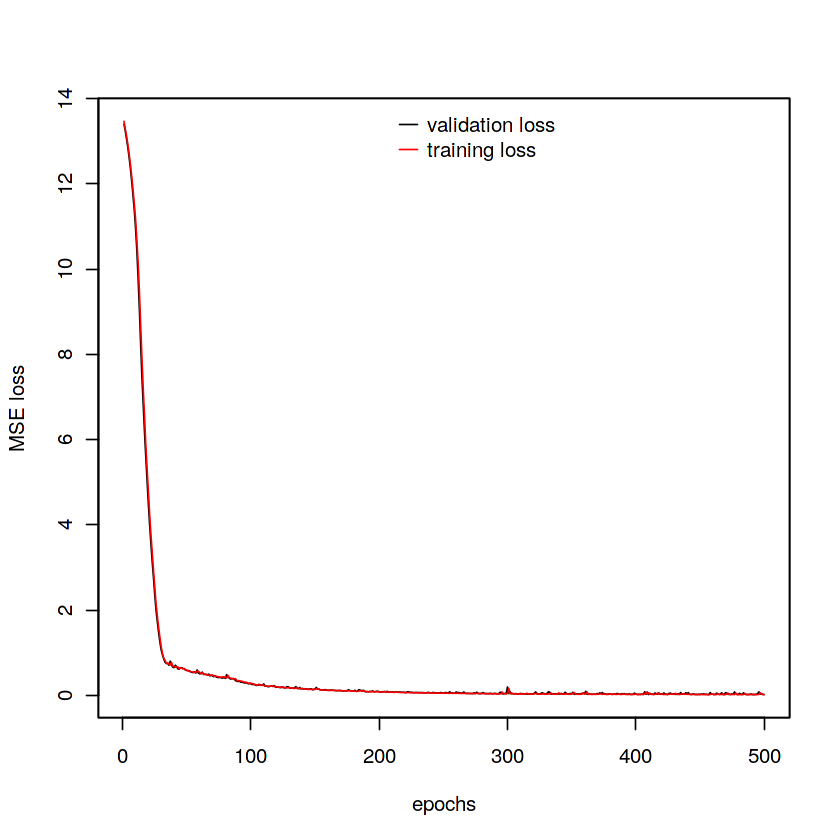

In [40]:
plot.zoo(cbind( fit[[2]]$val_loss, fit[[2]]$loss ), plot.type = "single",
     col = 1:2, type = c("l", "l"),
     xlab = "epochs",
     ylab = "MSE loss"
)
legend("top", c("validation loss", "training loss"), col = 1:2, lty = 1, bty = "n")

In [41]:
# forecast errors
load_model_weights_hdf5(model_1, "./CallBack/model_1")
Yhat_train <- as.vector(model_1 %>% predict(x_train))
Yhat_test <- as.vector(model_1 %>% predict(x_val))

train_err1 = mean( (Yhat_train - y_train)^2 )*10^2
test_err1 = mean((Yhat_test - y_val)^2)*10^2

round(c(train_err1, test_err1), 4)

[1] 1.8952 1.8238

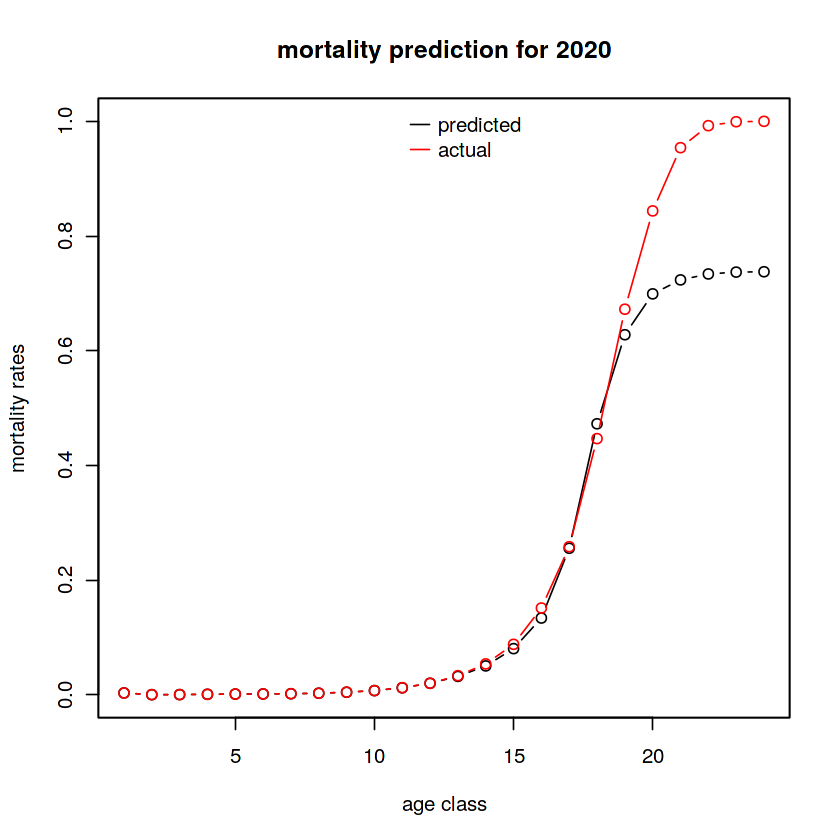

In [42]:
yhat1 = exp(-Yhat_test)
yval = exp(-y_val)
plot.zoo( cbind(yhat1, yval), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

## Shallow time-distributed LSTM, 1-step-ahead forecast

The ouput variable of the time-distributed T must be a $T \times 1$ vector for every $t = 1, ..., T$, where $T = 10$ as before.

$$
y_{T, x} = (log(m_1,x), ..., log(m_T, x))
$$

In [43]:
LSTM_TD = function(T, tau_0, tau_1){
    
    input = layer_input(shape = c(T, tau_0), dtype = "float32", name = "input")

    output = input %>%
        layer_lstm(units = tau_1, activation = "tanh", recurrent_activation = "tanh", 
                   return_sequences = TRUE, name = "LSTM1")  %>%
        time_distributed( layer_dense(units = 1, activation = k_exp, name = "output"), name = "TD")

    model = keras_model(inputs = list(input), outputs = c(output))
    model %>% compile( loss = "mean_squared_error", optimizer = "nadam")
}

In [44]:
t1 = nrow(train_rates) - (T - 1) - 1
a1 = ncol(train_rates) - (tau_0 - 1)
YT_td = array(NA, c(2, a1, T, 1))

for (t0 in 1:t1) {
  for (a0 in 1:a1) {
    YT_td[t0, a0, ,] <- train_rates[(t0 + 1):(T + t0), a0 + delta]
  }
}

y_train_td = array( -YT_td[1, , ,], dim = c(a1, T, 1) )
y_val_td = array( -YT_td[2, , ,], dim = c(a1, T, 1))

In [45]:
model_2 = LSTM_TD(T, tau_0, tau_1)
summary(model_2)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  (None, 10, 3)                   0           
________________________________________________________________________________
LSTM1 (LSTM)                        (None, 10, 5)                   180         
________________________________________________________________________________
TD (TimeDistributed)                (None, 10, 1)                   6           
Total params: 186
Trainable params: 186
Non-trainable params: 0
________________________________________________________________________________


In [46]:
CBs <- callback_model_checkpoint("./CallBack/model_2",
                                 monitor = "val_loss",
                                 verbose = 0,
                                 save_best_only = TRUE,
                                 save_weights_only = TRUE
)

t1 = Sys.time()
fit = model_2  %>% fit(x = x_train, 
                      y = y_train_td, 
                      validation_data = list(x_val, y_val_td), 
                      batch_size = 10, 
                      epochs = 500, 
                      callbacks = CBs,
                      verbose = 0)

(Sys.time() - t1)

Time difference of 20.98098 secs

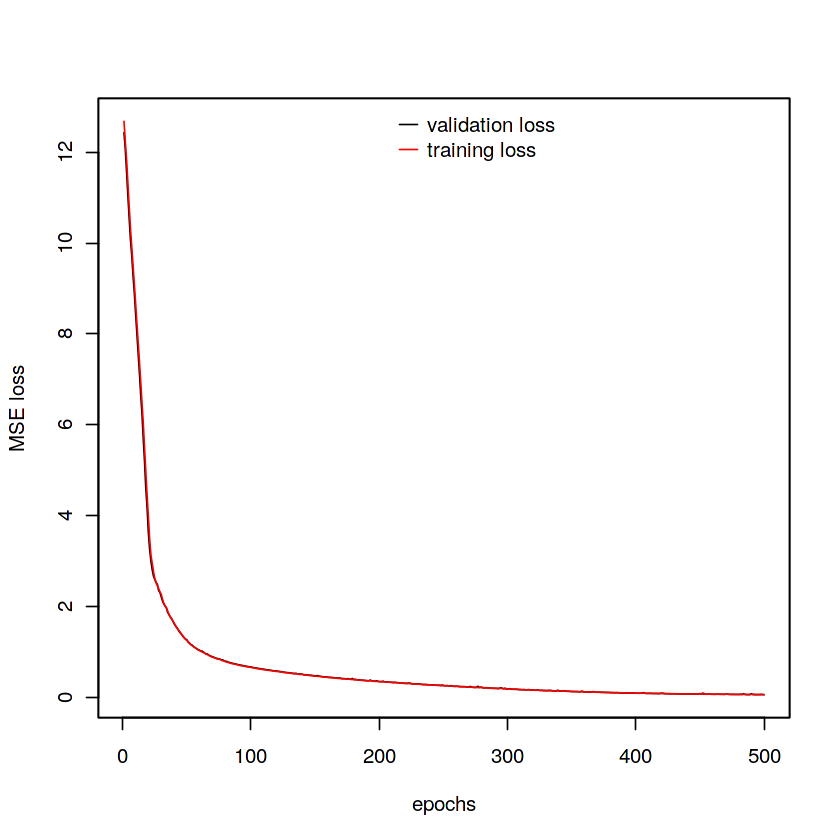

In [47]:
plot.zoo(cbind( fit[[2]]$val_loss, fit[[2]]$loss ), plot.type = "single",
     col = 1:2, type = c("l", "l"),
     xlab = "epochs",
     ylab = "MSE loss"
)
legend("top", c("validation loss", "training loss"), col = 1:2, lty = 1, bty = "n")

In [48]:
# forecast errors (for 2020 only)
load_model_weights_hdf5(model_2, "./CallBack/model_2")
Yhat_train <- as.vector(model_2 %>% predict(x_train))
Yhat_test <- as.vector(model_2 %>% predict(x_val))

train_err2 = mean( ( tail( Yhat_train, a1) - tail( y_train_td,  a1))^2 )*10^2
test_err2 = mean(( tail( Yhat_test, a1) -  tail( y_val_td,  a1))^2)*10^2

round(c(train_err2, test_err2), 4)

[1] 0.8062 1.4026

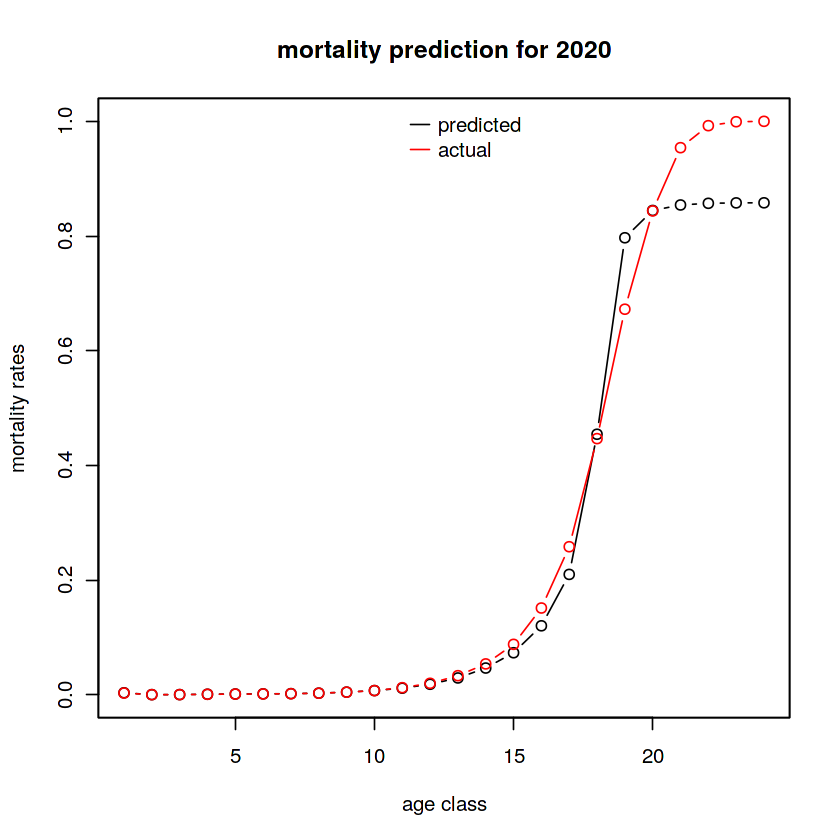

In [49]:
yhat2 = exp(-tail( Yhat_test, a1))
yval = exp(-tail( y_val_td, a1))
plot.zoo( cbind(yhat2, yval), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

## Shallow LSTM, T-step-ahead forecast

* Recursive prediction of total mortality rates in 2010-2020
* Use one lower and one higher age class to predict age class $x$ ($\tau_0 = 3$)

In [50]:
preprocessing = function(dati, H, tau_0, T = 10){
    
    train = dati[dati$TIME <= H, ]
    train = dcast(train, TIME ~ age, value.var = "logmx")
    
    # add padding
    train_rates = train
    for (i in 1:delta) {
        train_rates <- as.matrix(cbind(train_rates[, 1], 
                                       train_rates[, 2], 
                                       train_rates[, -1], 
                                       train_rates[, ncol(train_rates)]))
    }

    train_rates = train_rates[, -1]
    head(train_rates)
    
    a1 = ncol(train_rates) - (tau_0 - 1)
    t1 = nrow(train_rates) - (T - 1) - 1
    n_train = t1 * a1 # number of training samples
    
    # RNN inputs (nr_samples, nr_observations, nr_features)
    xt_train = array(NA, c(n_train, T, tau_0))
    YT_train = array(NA, c(n_train))

    for (t0 in 1:t1) {
      for (a0 in 1:a1) {
        xt_train[(t0 - 1) * a1 + a0, , ] <- as.matrix( train_rates[c(t0:(T + t0 - 1)), c(a0:(a0 + tau_0 - 1))] )
        YT_train[(t0 - 1) * a1 + a0] <- train_rates[T + t0, a0 + delta]
      }
    }
    
    return(list(xt = xt_train, yt = YT_train))
}

In [51]:
final_yr = max( unique( dati_istat$TIME ) )

recursive_forecast = function(data, model, H, xt_train, tau_0, T = 10){
    
    error = forecast = actual = NULL
    for( yr in ((H + 1):final_yr)){

        dati_sel = dati_istat[dati_istat$TIME >= (yr - T), ]

        data_prep = preprocessing(dati_sel, H = yr, tau_0)

        # test set
        x_scale = 2*(data_prep$xt - min(xt_train))/(min(xt_train) - max(xt_train)) - 1 
        x_test = array(x_scale, dim = dim(data_prep$xt))
        y_test = -data_prep$yt

        # predictions
        yhat_test = as.vector(model %>% predict(x_test))
        yhat_corr = exp(-yhat_test)

        fcst_err = mean((yhat_corr - exp(-y_test))^2)*10^2
        error = c(error, round(fcst_err, 4))
        forecast = cbind(forecast, yhat_corr)
        actual = cbind(actual, exp(-y_test))
    }

    colnames(forecast) = colnames(actual) = names(error) = (H + 1):final_yr
    
    return(list(error = error, forecast = forecast, actual = actual))
}


In [52]:
H = 2009

data_pre = preprocessing(dati_istat, H, tau_0)
xt_train = data_pre$xt
YT_train = data_pre$yt

x_train = 2*(xt_train - min(xt_train)) /(min(xt_train) - max(xt_train)) - 1
y_train = -YT_train

In [53]:
model_3 = shallow_LSTM(T, tau_0)
summary(model_3)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  (None, 10, 3)                   0           
________________________________________________________________________________
LSTM (LSTM)                         (None, 5)                       180         
________________________________________________________________________________
output (Dense)                      (None, 1)                       6           
Total params: 186
Trainable params: 186
Non-trainable params: 0
________________________________________________________________________________


In [54]:
CBs <- callback_model_checkpoint("./CallBack/model_3",
                                 monitor = "val_loss",
                                 verbose = 0,
                                 save_best_only = TRUE,
                                 save_weights_only = TRUE
)

t1 = Sys.time()
fit = model_3  %>% fit(x = x_train, 
                      y = y_train, 
                      validation_split = 0.2, 
                      batch_size = 10, 
                      epochs = 100, 
                      callbacks = CBs,
                      verbose = 0)

(Sys.time() - t1)

Time difference of 45.53839 secs

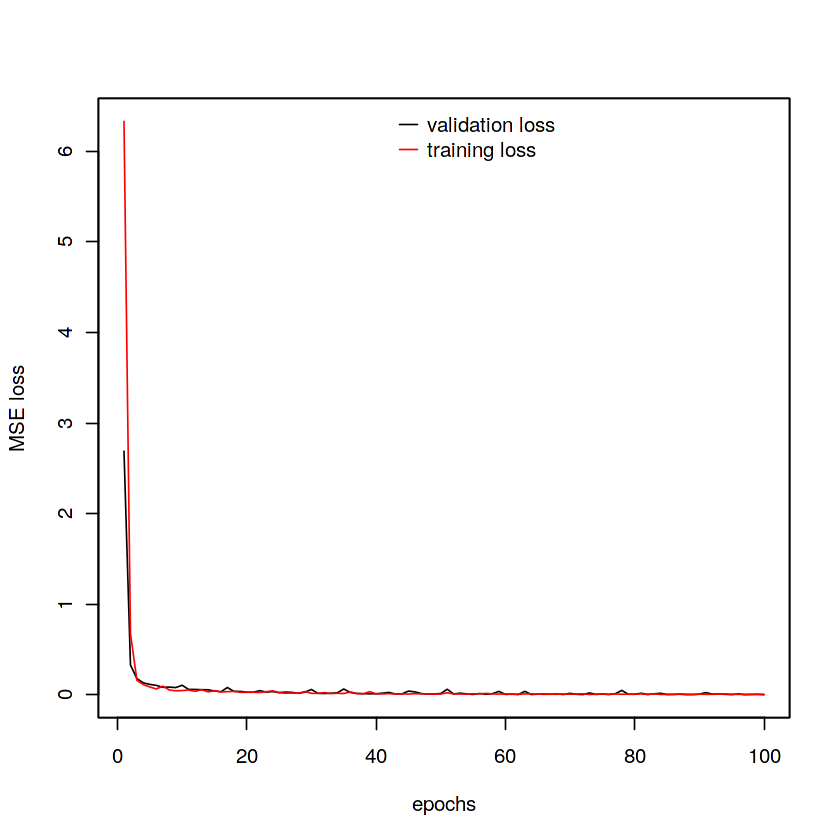

In [55]:
plot.zoo(cbind( fit[[2]]$val_loss, fit[[2]]$loss ), plot.type = "single",
     col = 1:2, type = c("l", "l"),
     xlab = "epochs",
     ylab = "MSE loss"
)
legend("top", c("validation loss", "training loss"), col = 1:2, lty = 1, bty = "n")

In [56]:
load_model_weights_hdf5(model_3, "./CallBack/model_3")
yhat_train <- as.vector(model_3 %>% predict(x_train))
train_err3 = mean( (yhat_train - y_train)^2 )*10^2
train_err3

[1] 0.4757443

In [57]:
# recursive predictions
pred_rec = recursive_forecast(dati_istat, model = model_3, H = 2009,
                              xt_train = xt_train, tau_0)
test_error3 = pred_rec$error
test_error3

2010   2011   2012   2013   2014   2015   2016   2017   2018   2019   2020 
0.0924 0.1002 0.0995 0.0989 0.0998 0.1028 0.1078 0.1162 0.1155 0.1028 0.1422

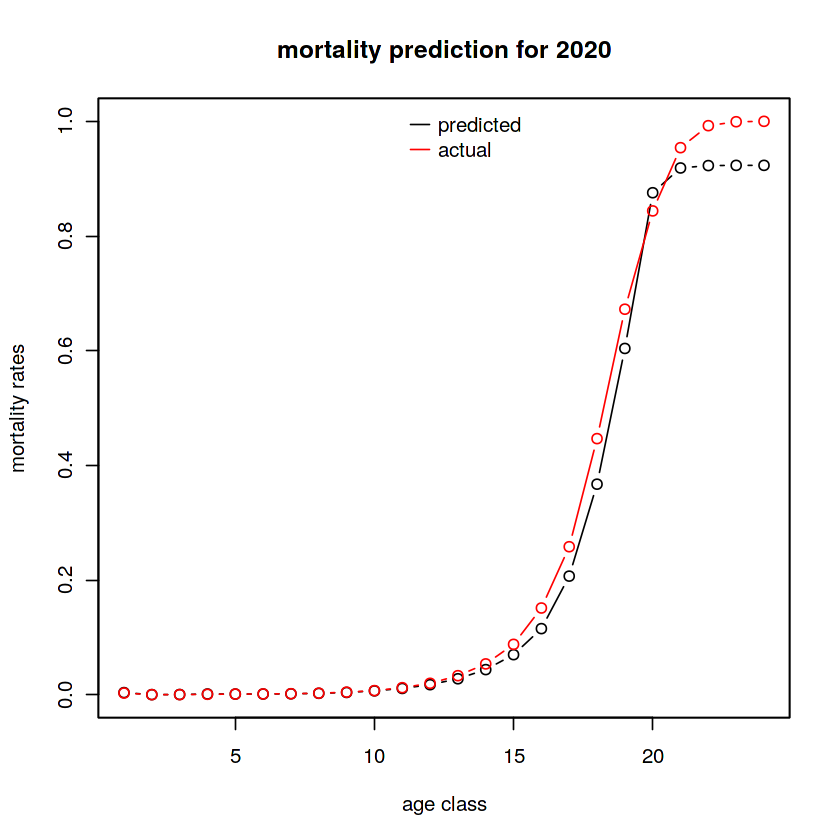

In [58]:
yhat3 = pred_rec$forecast[, "2020"]
yval = pred_rec$actual[, "2020"]
plot.zoo( cbind(yhat3, yval), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

## LSTM with 3 layers

* Recursive prediction of total mortality rates in 2010-2020
* Use adjacent age classes and two higher age classes to predict age class $x$ ($\tau_0 = 3$)

In [59]:
LSTM3 <- function(T, tau_0, tau_1, tau_2, tau_3, y_0 = 0) {
  Input <- layer_input(shape = c(T, tau_0),
                       dtype = 'float32',
                       name = 'Input')
  Output <- Input %>%
    layer_lstm(units = tau_1,
               activation = 'tanh',
               recurrent_activation = 'tanh',
               return_sequences = TRUE,
               name = 'LSTM1'
    ) %>%
    layer_lstm(units = tau_2,
               activation = 'tanh',
               recurrent_activation = 'tanh',
               return_sequences = TRUE,
               name = 'LSTM2'
    ) %>%
    layer_lstm(units = tau_3,
               activation = 'tanh',
               recurrent_activation = 'tanh',
               name = 'LSTM3'
    ) %>%
    layer_dense(units = 1,
                activation = k_exp,
                name = "Output",
                weights = list(array(0, dim = c(tau_3, 1)), 
                               array(log(y_0), dim = c(1)))
    )
  model <- keras_model(inputs = list(Input), outputs = c(Output))
  model %>% compile(loss = 'mean_squared_error', optimizer = "nadam")
}

In [60]:
# parameters
T = 10
tau_0 = 3
tau_1 = 20
tau_2 = 15
tau_3 = 10
H = 2009

In [61]:
# preprocessing
data_pre = preprocessing(dati_istat, H, tau_0 = tau_0)
xt_train = data_pre$xt
YT_train = data_pre$yt

In [62]:
# scale data
x_train = 2*(xt_train - min(xt_train)) /(min(xt_train) - max(xt_train)) - 1
y_train = -YT_train
y_0 = mean(y_train)

In [63]:
model_4 = LSTM3(T, tau_0, tau_1, tau_2, tau_3, y_0 = y_0)
summary(model_4)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 10, 3)                   0           
________________________________________________________________________________
LSTM1 (LSTM)                        (None, 10, 20)                  1920        
________________________________________________________________________________
LSTM2 (LSTM)                        (None, 10, 15)                  2160        
________________________________________________________________________________
LSTM3 (LSTM)                        (None, 10)                      1040        
________________________________________________________________________________
Output (Dense)                      (None, 1)                       11          
Total params: 5,131
Trainable params: 5,131
Non-trainable params: 0
_________________________________________

In [64]:
CBs <- callback_model_checkpoint("./CallBack/model_4",
                                 monitor = "val_loss",
                                 verbose = 0,
                                 save_best_only = TRUE,
                                 save_weights_only = TRUE
)

t1 = Sys.time()
fit = model_4  %>% fit(x = x_train, 
                      y = y_train, 
                      validation_split = 0.2, 
                      batch_size = 10, 
                      epochs = 100, 
                      callbacks = CBs,
                      verbose = 0)

(Sys.time() - t1)

Time difference of 1.701488 mins

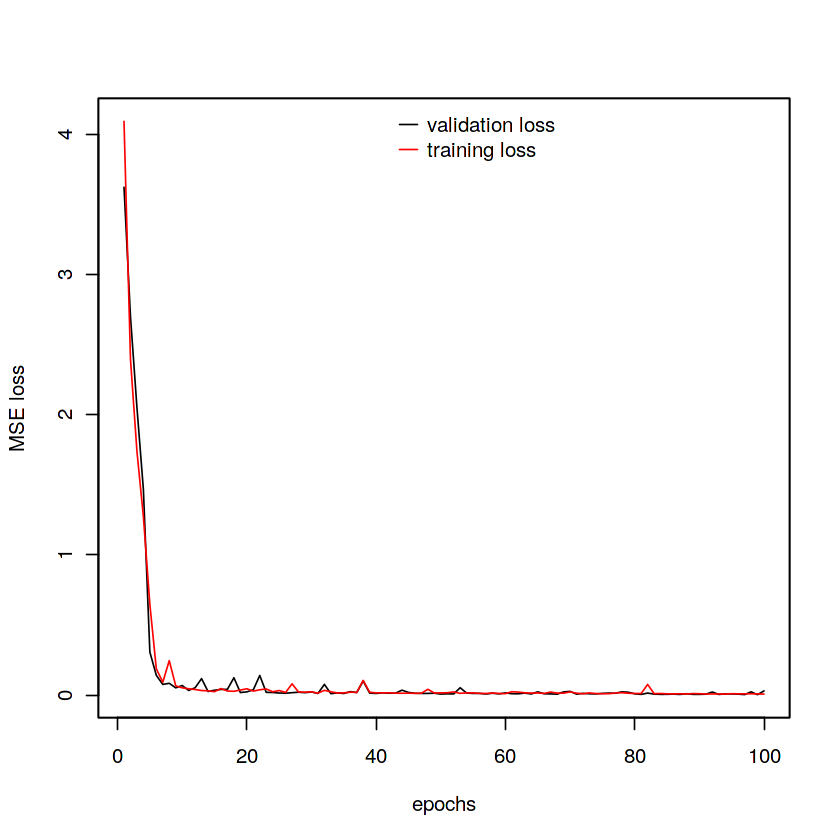

In [65]:
plot.zoo(cbind( fit[[2]]$val_loss, fit[[2]]$loss ), plot.type = "single",
     col = 1:2, type = c("l", "l"),
     xlab = "epochs",
     ylab = "MSE loss"
)
legend("top", c("validation loss", "training loss"), col = 1:2, lty = 1, bty = "n")

In [66]:
load_model_weights_hdf5(model_4, "./CallBack/model_4")
yhat_train <- as.vector(model_4 %>% predict(x_train))
train_err4 = mean( (yhat_train - y_train)^2 )*10^2
train_err4

[1] 0.5322737

In [67]:
# recursive predictions
pred_rec = recursive_forecast(dati_istat, model = model_4, H = 2009, 
                              xt_train = xt_train, tau_0 = tau_0)
test_error4 = pred_rec$error
test_error4

2010   2011   2012   2013   2014   2015   2016   2017   2018   2019   2020 
0.0540 0.0509 0.0610 0.0505 0.0472 0.0746 0.0527 0.0708 0.0575 0.0548 0.1366

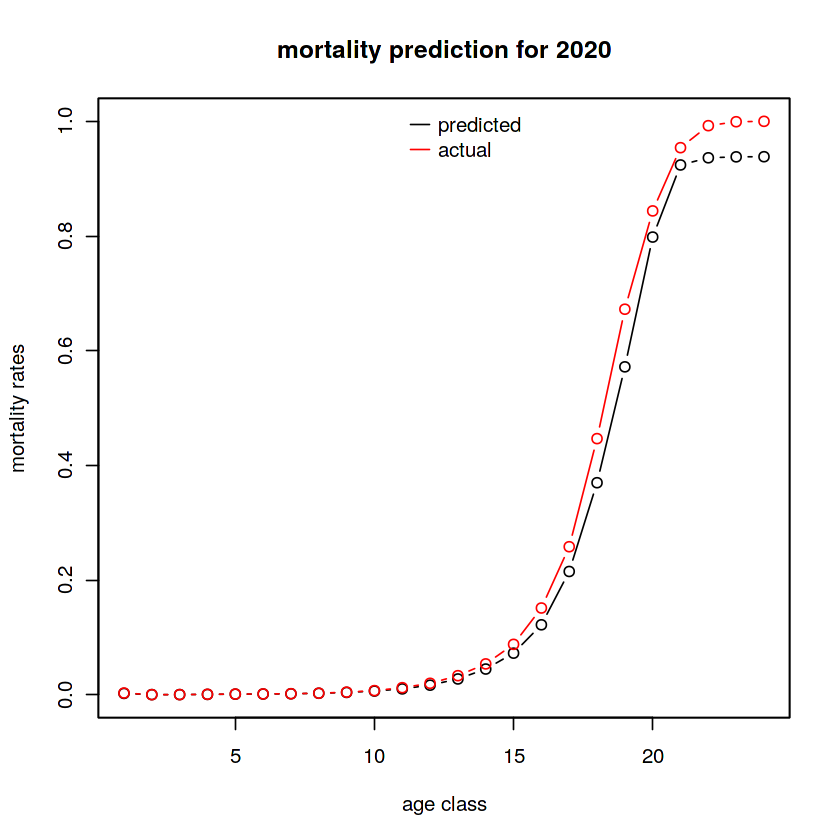

In [68]:
yhat4 = pred_rec$forecast[, "2020"]
yval = pred_rec$actual[, "2020"]
plot.zoo( cbind(yhat4, yval), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

## GRU with 3 layers

* Recursive prediction of total mortality rates in 2010-2020
* Use adjacent age classes and two higher age classes to predict age class $x$ ($\tau_0 = 3$)

In [69]:
GRU3 <- function(T, tau_0, tau_1, tau_2, tau_3, y_0 = 0) {
    
  Input <- layer_input(shape = c(T, tau_0),
                       dtype = 'float32',
                       name = 'Input')
  Output <- Input %>%
    layer_gru(units = tau_1,
              activation = 'tanh',
              recurrent_activation = 'tanh',
              return_sequences = TRUE,
              name = 'GRU1'
    ) %>%
    layer_gru(units = tau_2,
              activation = 'tanh',
              recurrent_activation = 'tanh',
              return_sequences = TRUE,
              name = 'GRU2'
    ) %>%
    layer_gru(units = tau_3,
              activation = 'tanh',
              recurrent_activation = 'tanh',
              name = 'GRU3'
    ) %>%
    layer_dense(units = 1,
                activation = k_exp,
                name = "Output",
                weights = list(array(0, dim = c(tau_3, 1)), 
                               array(log(y_0), dim = c(1)))
    )
  model <- keras_model(inputs = list(Input), outputs = c(Output))
  model %>% compile(loss = 'mean_squared_error', optimizer = "nadam")
}

In [70]:
# parameters
T = 10
tau_0 = 3
tau_1 = 20
tau_2 = 15
tau_3 = 10
H = 2009

In [71]:
# preprocessing
data_pre = preprocessing(dati_istat, H, tau_0 = tau_0)
xt_train = data_pre$xt
YT_train = data_pre$yt

In [72]:
# scale data
x_train = 2*(xt_train - min(xt_train)) /(min(xt_train) - max(xt_train)) - 1
y_train = -YT_train
y_0 = mean(y_train)

In [73]:
model_5 = GRU3(T, tau_0, tau_1, tau_2, tau_3, y_0 = y_0)
summary(model_5)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 10, 3)                   0           
________________________________________________________________________________
GRU1 (GRU)                          (None, 10, 20)                  1440        
________________________________________________________________________________
GRU2 (GRU)                          (None, 10, 15)                  1620        
________________________________________________________________________________
GRU3 (GRU)                          (None, 10)                      780         
________________________________________________________________________________
Output (Dense)                      (None, 1)                       11          
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
_________________________________________

In [74]:
CBs <- callback_model_checkpoint("./CallBack/model_5",
                                 monitor = "val_loss",
                                 verbose = 0,
                                 save_best_only = TRUE,
                                 save_weights_only = TRUE
)

t1 = Sys.time()
fit = model_5  %>% fit(x = x_train, 
                      y = y_train, 
                      validation_split = 0.2, 
                      batch_size = 10, 
                      epochs = 100, 
                      callbacks = CBs,
                      verbose = 0)

(Sys.time() - t1)

Time difference of 1.546184 mins

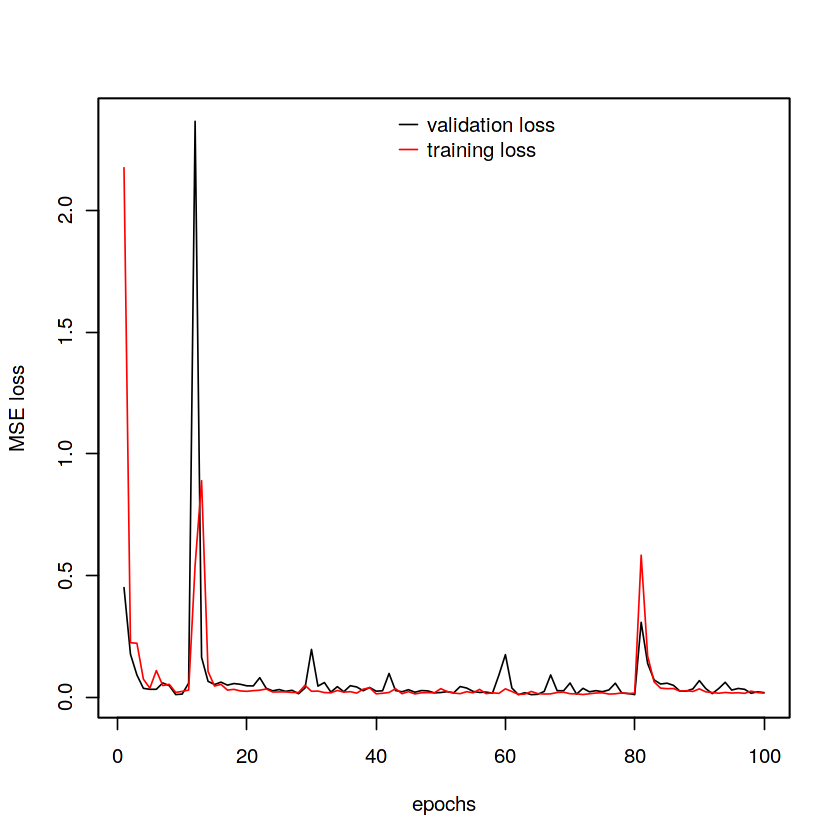

In [75]:
plot.zoo(cbind( fit[[2]]$val_loss, fit[[2]]$loss ), plot.type = "single",
     col = 1:2, type = c("l", "l"),
     xlab = "epochs",
     ylab = "MSE loss"
)
legend("top", c("validation loss", "training loss"), col = 1:2, lty = 1, bty = "n")

In [76]:
load_model_weights_hdf5(model_5, "./CallBack/model_5")
yhat_train <- as.vector(model_5 %>% predict(x_train))
train_err5 = mean( (yhat_train - y_train)^2 )*10^2
train_err5

[1] 1.411138

In [77]:
# recursive predictions
pred_rec = recursive_forecast(dati_istat, model = model_5, H = 2009, 
                              xt_train = xt_train, tau_0 = tau_0)
test_error5 = pred_rec$error
test_error5

2010   2011   2012   2013   2014   2015   2016   2017   2018   2019   2020 
0.1157 0.1044 0.1483 0.0885 0.1044 0.1387 0.0992 0.1284 0.0993 0.0984 0.2225

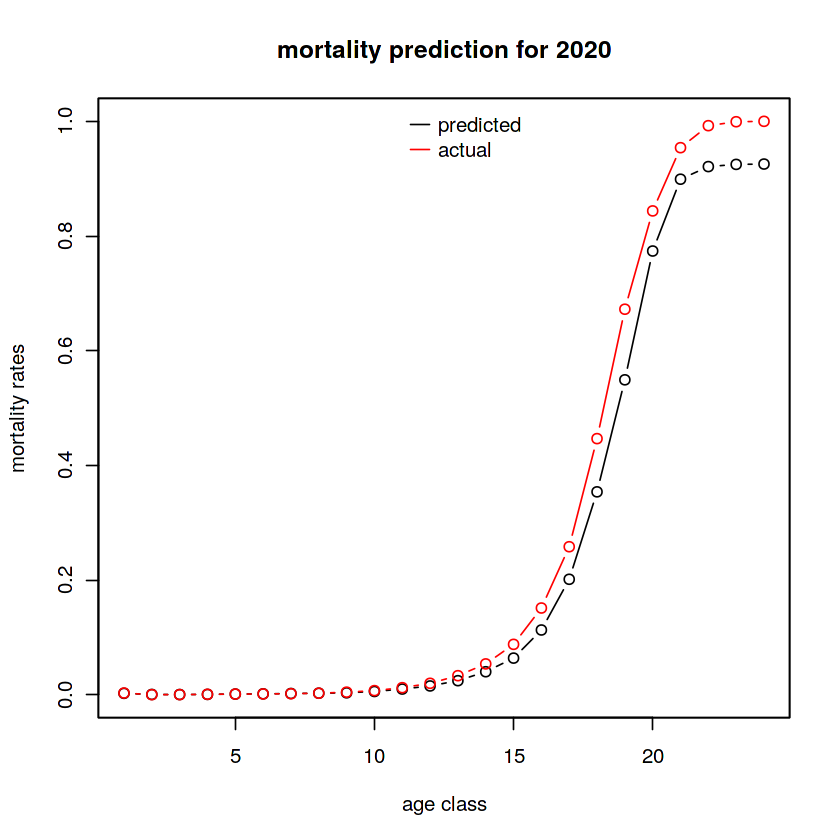

In [78]:
yhat5 = pred_rec$forecast[, "2020"]
yval = pred_rec$actual[, "2020"]
plot.zoo( cbind(yhat5, yval), plot.type = "single", col = 1:2, type = "b", 
        ylab = "mortality rates", xlab = "age class", main = "mortality prediction for 2020")
legend("top", c("predicted", "actual"), col = 1:2, lty = 1, bty = "n")

## Compare forecasts for 2020

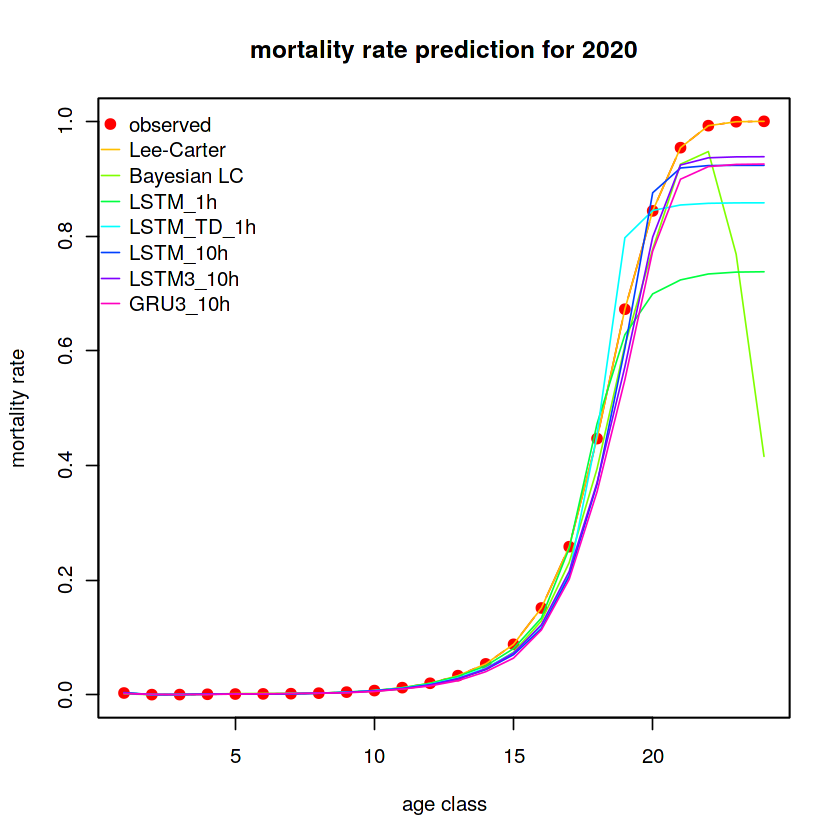

In [79]:
yy = cbind(yval, yhat0, yhat01, yhat1, yhat2, yhat3, yhat4, yhat5)
models = c("observed","Lee-Carter","Bayesian LC","LSTM_1h", "LSTM_TD_1h", "LSTM_10h", "LSTM3_10h", "GRU3_10h")
colnames(yy) = models

plot.zoo(yy, plot.type = "single", col = rainbow(ncol(yy)),
         type = c("b", rep("l", length(models)-1)), pch = c(19, rep(NA, length(models)-1)), 
        main = "mortality rate prediction for 2020", ylab = "mortality rate", xlab = "age class")
legend("topleft", colnames(yy), col = rainbow(ncol(yy)), lty =c(NA, rep(1, length(models)-1)),
       pch = c(19, rep(NA, length(models)-1)), bty = "n")

LSTM_1h  LSTM_TD_1h Bayesian LC    GRU3_10h    LSTM_10h   LSTM3_10h 
     1.8238      1.4026      1.3132      0.2225      0.1422      0.1366 
 Lee-Carter 
     0.0129

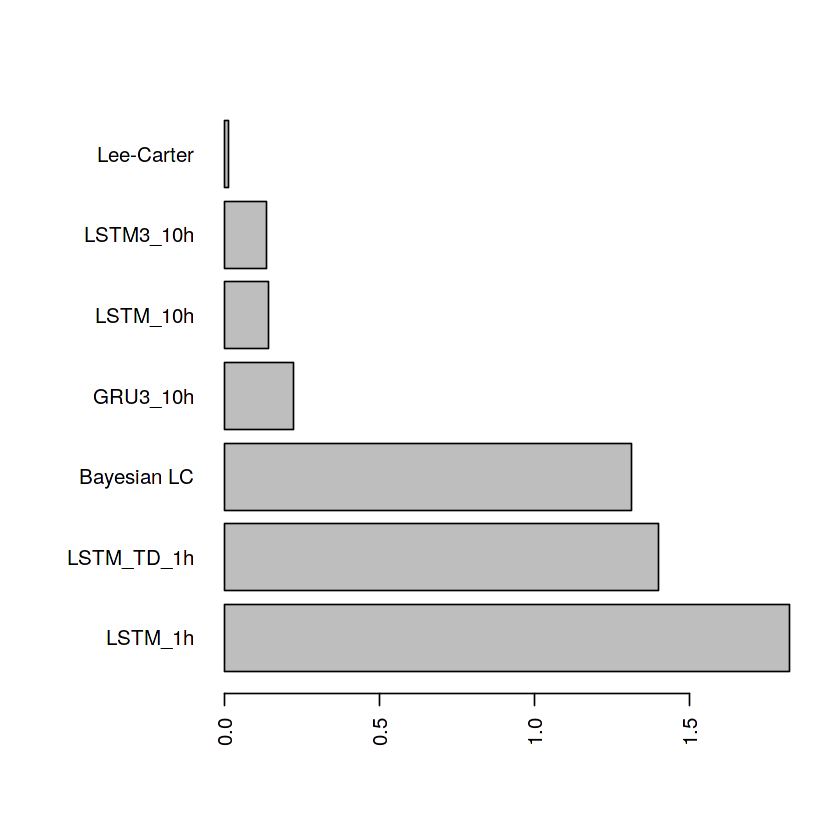

In [80]:
test_error = c(test_err0, test_err01, test_err1,  test_err2,  tail( test_error3, 1),
               tail( test_error4, 1),  tail( test_error5, 1) )
names(test_error) = models[-1]

tr = sort(test_error, decreasing = TRUE)
round( tr, 4 )

par(oma = c(1, 5, 0, 0))
b = barplot(tr, horiz = T, las = 2)
